In [1]:
import numpy as np
import os
from tqdm import tqdm

source = os.walk('./HW3')

# for folder, subfolder, file in source:
#     print(folder,subfolder,file) 

filepath = [folder + '/' + filename for folder, _ , file in source for filename in file] 
test = np.load(filepath[0])
train_inner_break = np.load(filepath[1])
train_normal = np.load(filepath[2]) 
train_outer_break = np.load(filepath[3])

train_normal.shape

(250, 10240)

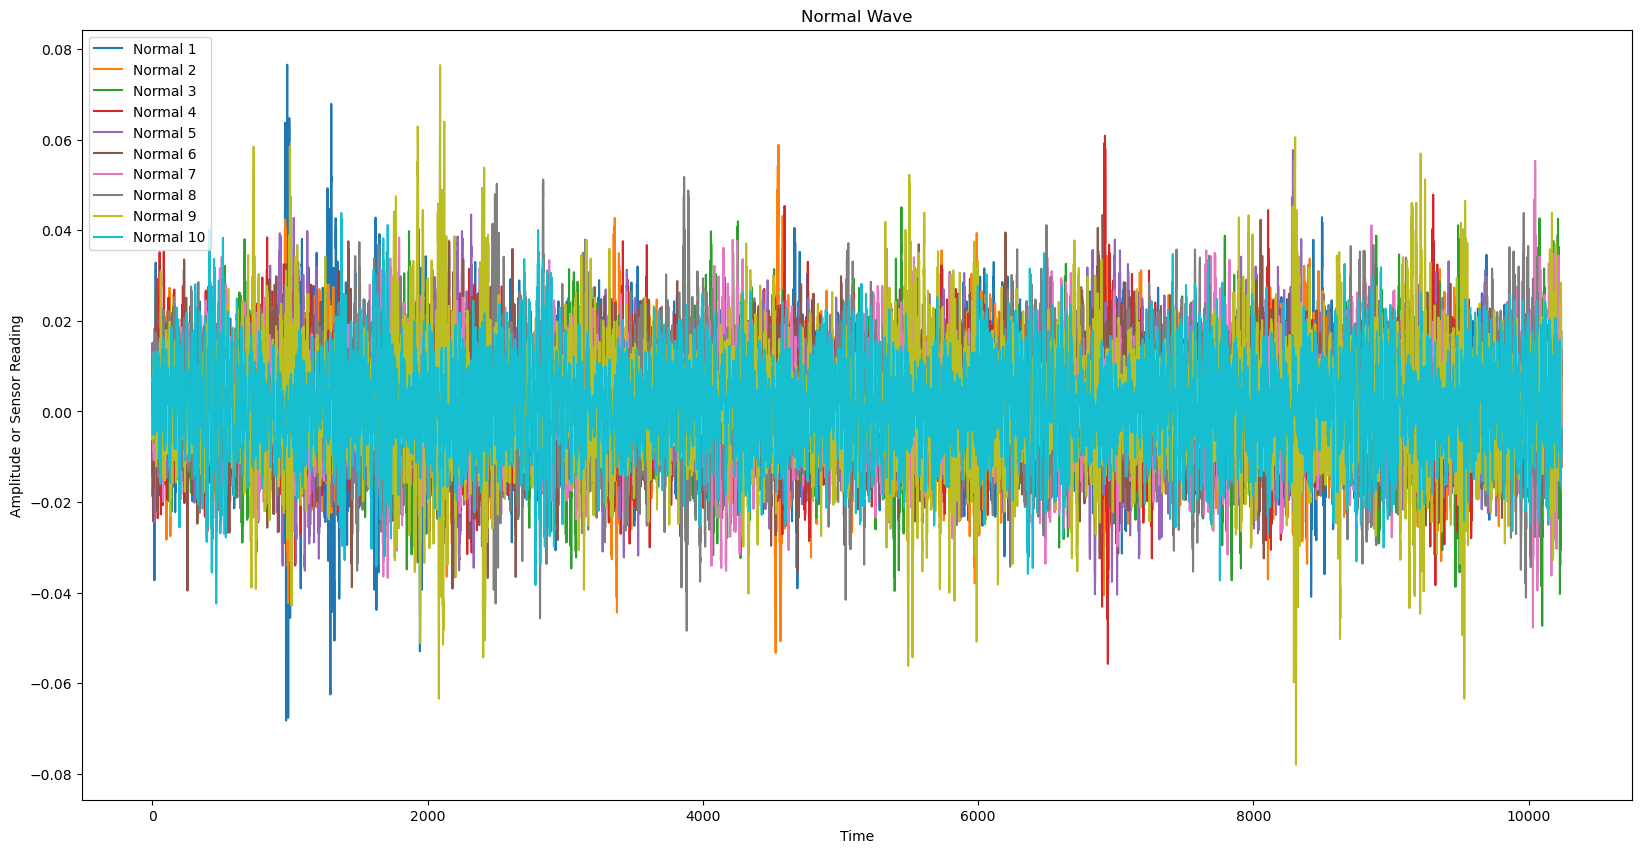

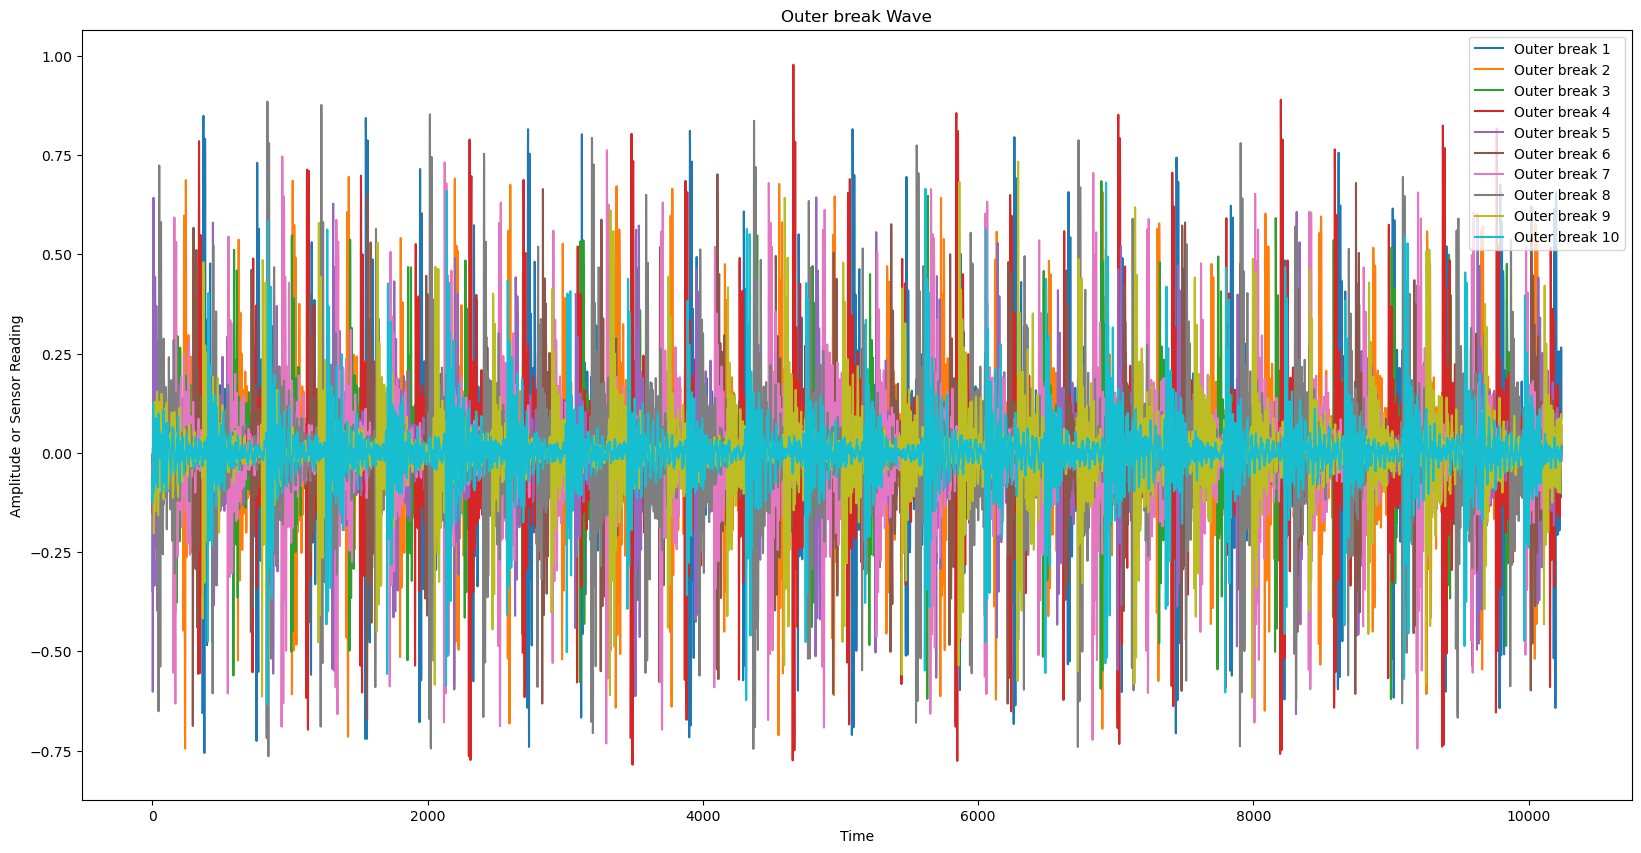

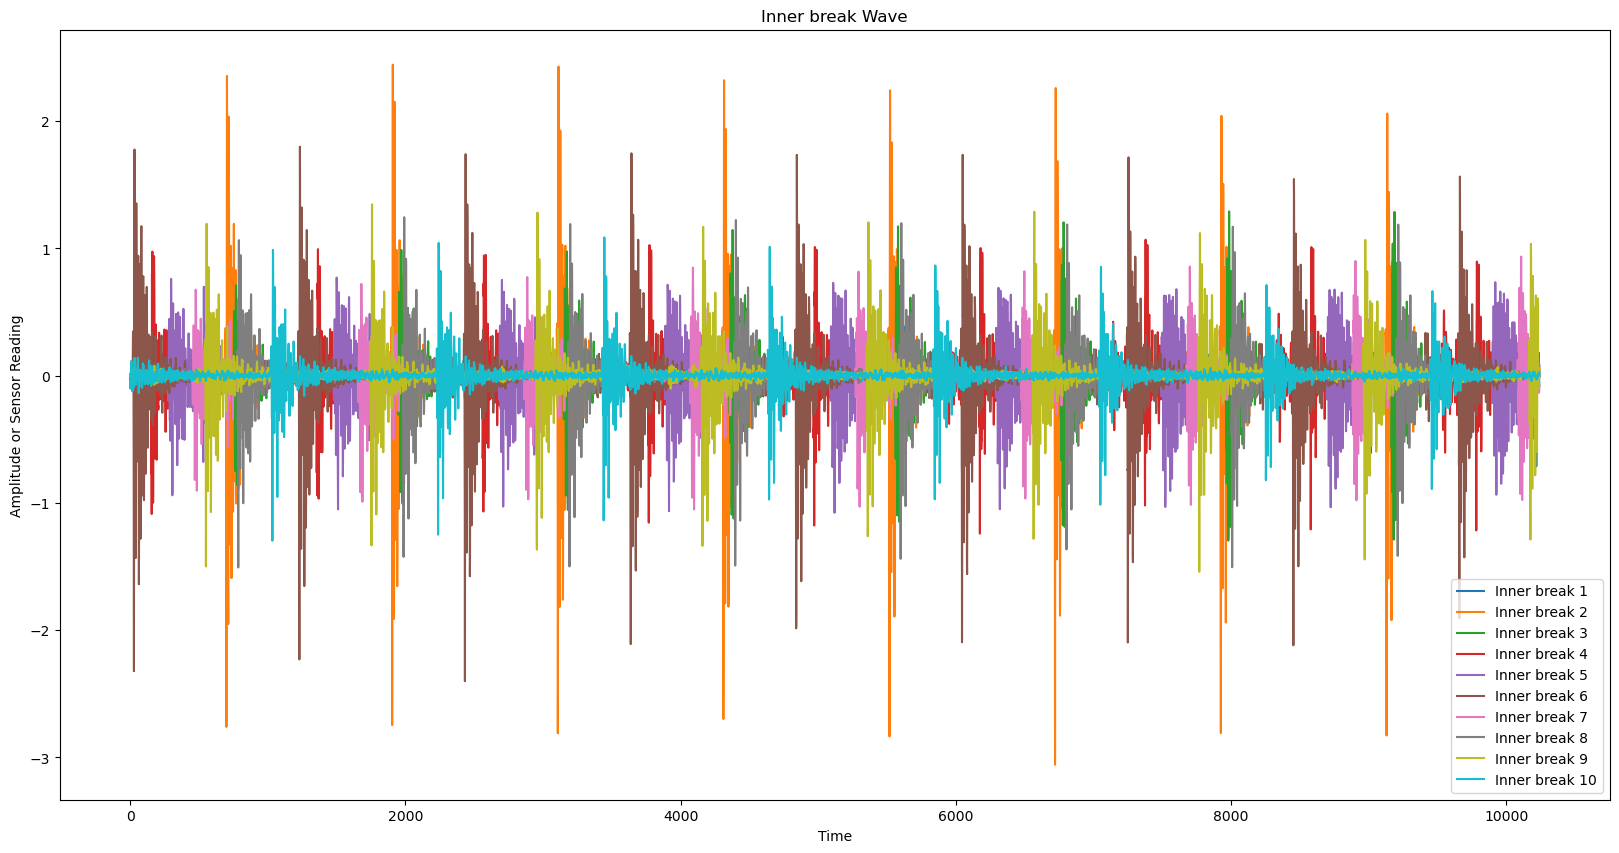

In [2]:
import matplotlib.pyplot as plt

x_axis = np.arange(10240)
smaple_num = 10

plt.figure(figsize=(20, 10))
for i in range(smaple_num):
    plt.plot(x_axis, train_normal[i], label=f'Normal {i+1}')
    
plt.title('Normal Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude or Sensor Reading')
plt.legend()
plt.show()



plt.figure(figsize=(20, 10))
for i in range(smaple_num):
    plt.plot(x_axis, train_outer_break[i], label=f'Outer break {i+1}')

plt.title('Outer break Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude or Sensor Reading')
plt.legend()
plt.show()



plt.figure(figsize=(20, 10))
for i in range(smaple_num):
    plt.plot(x_axis, train_inner_break[i], label=f'Inner break {i+1}')

plt.title('Inner break Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude or Sensor Reading')
plt.legend()
plt.show()


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

# def assign_labels(data, labels):
#     labels = np.full((data.shape[0],), labels)
#     return np.hstack((data, labels.reshape(-1,1)))

class WaveDataset(Dataset):
    def __init__(self, wave ,train = False, val = False, samplenum = 0):
        self.data = torch.tensor(wave[:,4000:6000], dtype=torch.float32)
        self.train = train
        self.val = val

        if self.train and self.val:
            self.labels = torch.tensor(np.concatenate((
                np.zeros(samplenum),
                np.ones(samplenum),
                np.ones(samplenum) * 2
            )),dtype=torch.long)
        
        elif self.train:
            self.labels = torch.tensor(np.concatenate((
                np.zeros(250),
                np.ones(250),
                np.ones(250)*2
            )),dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.train:
            return self.data[idx], self.labels[idx]
        else:
            return self.data[idx] 

val_split_flag = True
val_rate = 0.3
split_num = int(250*(1-val_rate))

if val_split_flag:
    training_set = np.concatenate((train_normal[:split_num], train_outer_break[:split_num], train_inner_break[:split_num]))  
    training_set = WaveDataset(training_set, train = True, val = True, samplenum= split_num)
    train_loader = DataLoader(training_set, batch_size = 32, shuffle = True)
    val_set = np.concatenate((train_normal[split_num:], train_outer_break[split_num:], train_inner_break[split_num:]))
    val_set = WaveDataset(val_set, train = True, val = True, samplenum = 250 - split_num)
    val_loader = DataLoader(val_set, batch_size = 32, shuffle = True) 
else:
    training_set = np.concatenate((train_normal,train_outer_break,train_inner_break))
    training_set = WaveDataset(training_set, train = True, val = False)
    train_loader = DataLoader(training_set, batch_size = 32, shuffle = True)

test_set = WaveDataset(test)
test_loader = DataLoader(test_set, batch_size = 32, shuffle = True) 


ModuleNotFoundError: No module named 'torch'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(2)
        #self.conv2 = nn.Conv1d(16, 32, 5, stride=1, padding=0)
        #self.bn2 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size=1) 
        self.fc1 = nn.Linear(2 * 1, 3)  
        #self.fc2 = nn.Linear(128, 3)  

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        x = self.adaptive_pool(x)  # Adaptive average pooling to get a fixed size output
        x = x.view(-1, 2*1)  # Flatten the tensor
        #x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x


model = MyCNN()

print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")



MyCNN(
  (conv1): Conv1d(1, 2, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=2, out_features=3, bias=True)
)
Total number of trainable parameters: 29


In [ ]:
# training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    
    
    for inputs, labels in tqdm(train_loader, desc = f'train_samples:{len(train_loader.dataset)}'):

        inputs = inputs.unsqueeze(1)  # (batch_size, channels, length)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], phase: train, Loss: {train_loss:.4f}, Train_Accuracy: {train_acc:.2f}%')

    if val_split_flag:
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader,desc = f'val_samples:{len(val_loader.dataset)}'):

                inputs = inputs.unsqueeze(1)  # (batch_size, channels, length)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = running_loss / len(val_loader) 
            val_acc = 100 * correct / total
            print(f'Epoch [{epoch+1}/{num_epochs}], phase: val, Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.2f}%')
        
            val_losses.append(val_loss)
            val_accs.append(val_acc)



print('Finished Training')

train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 23.29it/s]


Epoch [1/25], phase: train, Loss: 1.2055, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 298.65it/s]


Epoch [1/25], phase: val, Loss: 0.8578, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 143.63it/s]


Epoch [2/25], phase: train, Loss: 1.1777, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 145.15it/s]


Epoch [2/25], phase: val, Loss: 0.8147, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 51.12it/s]


Epoch [3/25], phase: train, Loss: 1.1476, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 313.24it/s]


Epoch [3/25], phase: val, Loss: 0.7556, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 150.43it/s]


Epoch [4/25], phase: train, Loss: 1.1281, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 305.65it/s]


Epoch [4/25], phase: val, Loss: 0.7368, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 170.35it/s]


Epoch [5/25], phase: train, Loss: 1.1051, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 376.15it/s]


Epoch [5/25], phase: val, Loss: 0.7108, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 159.27it/s]


Epoch [6/25], phase: train, Loss: 1.0831, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 267.56it/s]


Epoch [6/25], phase: val, Loss: 0.7116, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 158.65it/s]


Epoch [7/25], phase: train, Loss: 1.0572, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 354.27it/s]


Epoch [7/25], phase: val, Loss: 0.7642, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 82.25it/s]


Epoch [8/25], phase: train, Loss: 1.0368, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 470.50it/s]


Epoch [8/25], phase: val, Loss: 0.7529, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 163.65it/s]


Epoch [9/25], phase: train, Loss: 1.0226, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 511.23it/s]


Epoch [9/25], phase: val, Loss: 0.7662, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 159.84it/s]


Epoch [10/25], phase: train, Loss: 1.0002, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 259.27it/s]


Epoch [10/25], phase: val, Loss: 0.7633, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 141.71it/s]


Epoch [11/25], phase: train, Loss: 0.9839, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 335.51it/s]


Epoch [11/25], phase: val, Loss: 0.8062, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 173.37it/s]


Epoch [12/25], phase: train, Loss: 0.9702, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 476.12it/s]


Epoch [12/25], phase: val, Loss: 0.8008, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 75.23it/s]


Epoch [13/25], phase: train, Loss: 0.9535, Train_Accuracy: 47.62%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 356.56it/s]


Epoch [13/25], phase: val, Loss: 0.8191, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 144.53it/s]


Epoch [14/25], phase: train, Loss: 0.9440, Train_Accuracy: 47.81%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 374.61it/s]


Epoch [14/25], phase: val, Loss: 0.8597, Val_Accuracy: 48.89%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 138.54it/s]


Epoch [15/25], phase: train, Loss: 0.9286, Train_Accuracy: 49.71%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 471.15it/s]


Epoch [15/25], phase: val, Loss: 0.8746, Val_Accuracy: 30.67%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 156.93it/s]


Epoch [16/25], phase: train, Loss: 0.9139, Train_Accuracy: 60.38%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 291.87it/s]


Epoch [16/25], phase: val, Loss: 0.8705, Val_Accuracy: 46.22%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 167.41it/s]


Epoch [17/25], phase: train, Loss: 0.9072, Train_Accuracy: 77.33%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 474.99it/s]


Epoch [17/25], phase: val, Loss: 0.8834, Val_Accuracy: 36.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 73.47it/s]


Epoch [18/25], phase: train, Loss: 0.8969, Train_Accuracy: 80.76%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 486.36it/s]


Epoch [18/25], phase: val, Loss: 0.8758, Val_Accuracy: 42.67%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 160.62it/s]


Epoch [19/25], phase: train, Loss: 0.8937, Train_Accuracy: 80.38%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 554.22it/s]


Epoch [19/25], phase: val, Loss: 0.8895, Val_Accuracy: 34.22%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 158.55it/s]


Epoch [20/25], phase: train, Loss: 0.8793, Train_Accuracy: 81.14%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 200.95it/s]


Epoch [20/25], phase: val, Loss: 0.8757, Val_Accuracy: 42.67%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 164.37it/s]


Epoch [21/25], phase: train, Loss: 0.8750, Train_Accuracy: 80.19%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 382.23it/s]


Epoch [21/25], phase: val, Loss: 0.8857, Val_Accuracy: 35.56%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 165.12it/s]


Epoch [22/25], phase: train, Loss: 0.8644, Train_Accuracy: 80.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 376.98it/s]


Epoch [22/25], phase: val, Loss: 0.9238, Val_Accuracy: 32.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 75.64it/s]


Epoch [23/25], phase: train, Loss: 0.8589, Train_Accuracy: 80.38%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 391.68it/s]


Epoch [23/25], phase: val, Loss: 1.0232, Val_Accuracy: 0.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 154.75it/s]


Epoch [24/25], phase: train, Loss: 0.8519, Train_Accuracy: 80.19%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 355.68it/s]


Epoch [24/25], phase: val, Loss: 0.9788, Val_Accuracy: 0.00%


train_samples:525: 100%|██████████| 17/17 [00:00<00:00, 157.82it/s]


Epoch [25/25], phase: train, Loss: 0.8544, Train_Accuracy: 80.19%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 434.75it/s]

Epoch [25/25], phase: val, Loss: 0.9648, Val_Accuracy: 20.89%
Finished Training


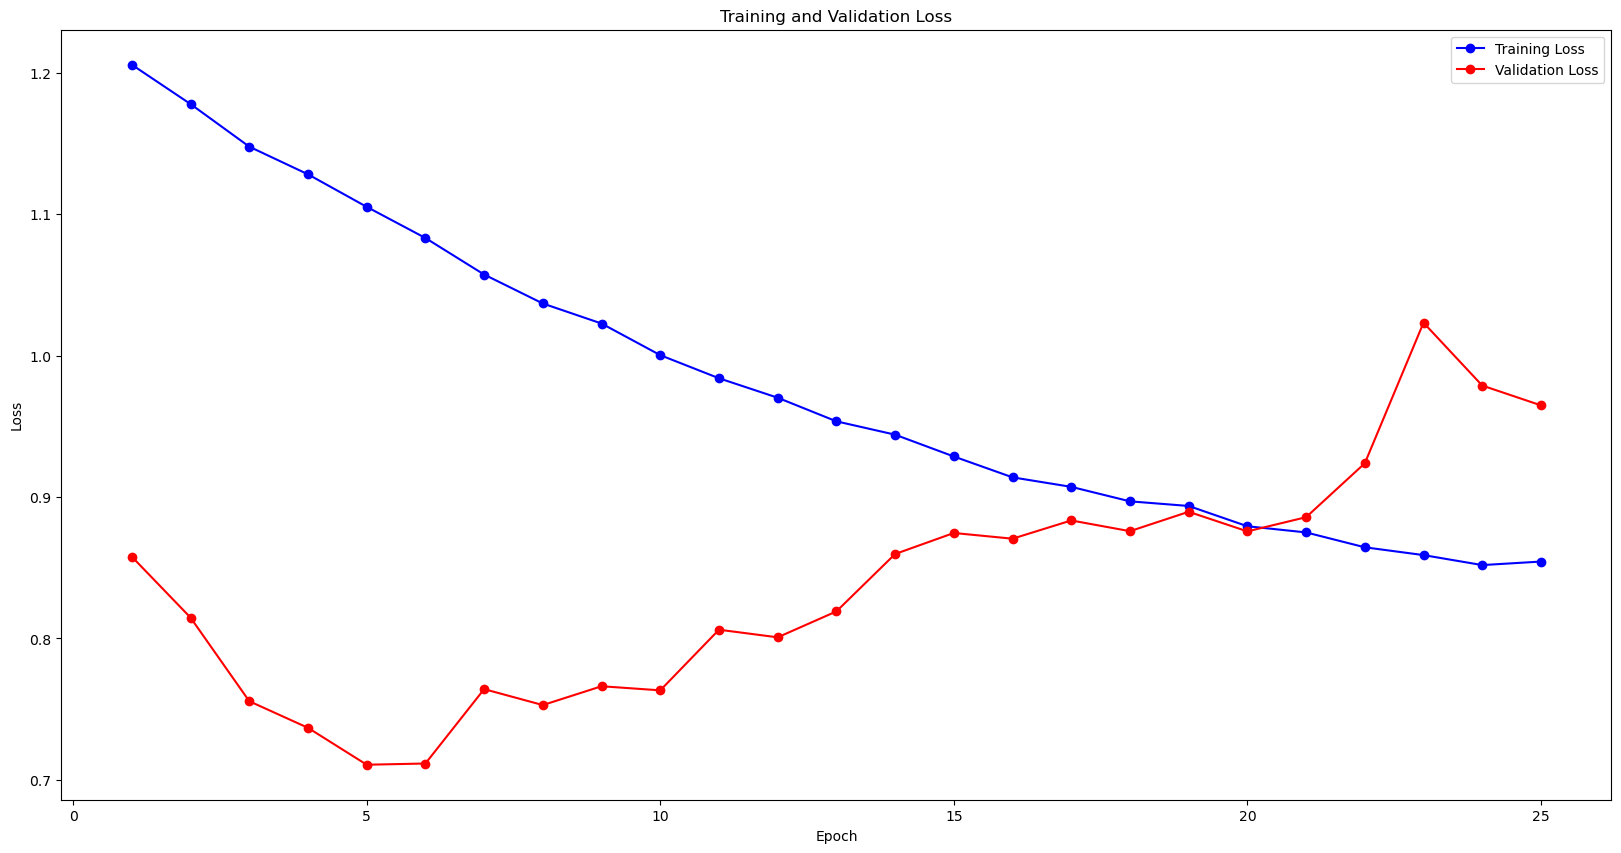

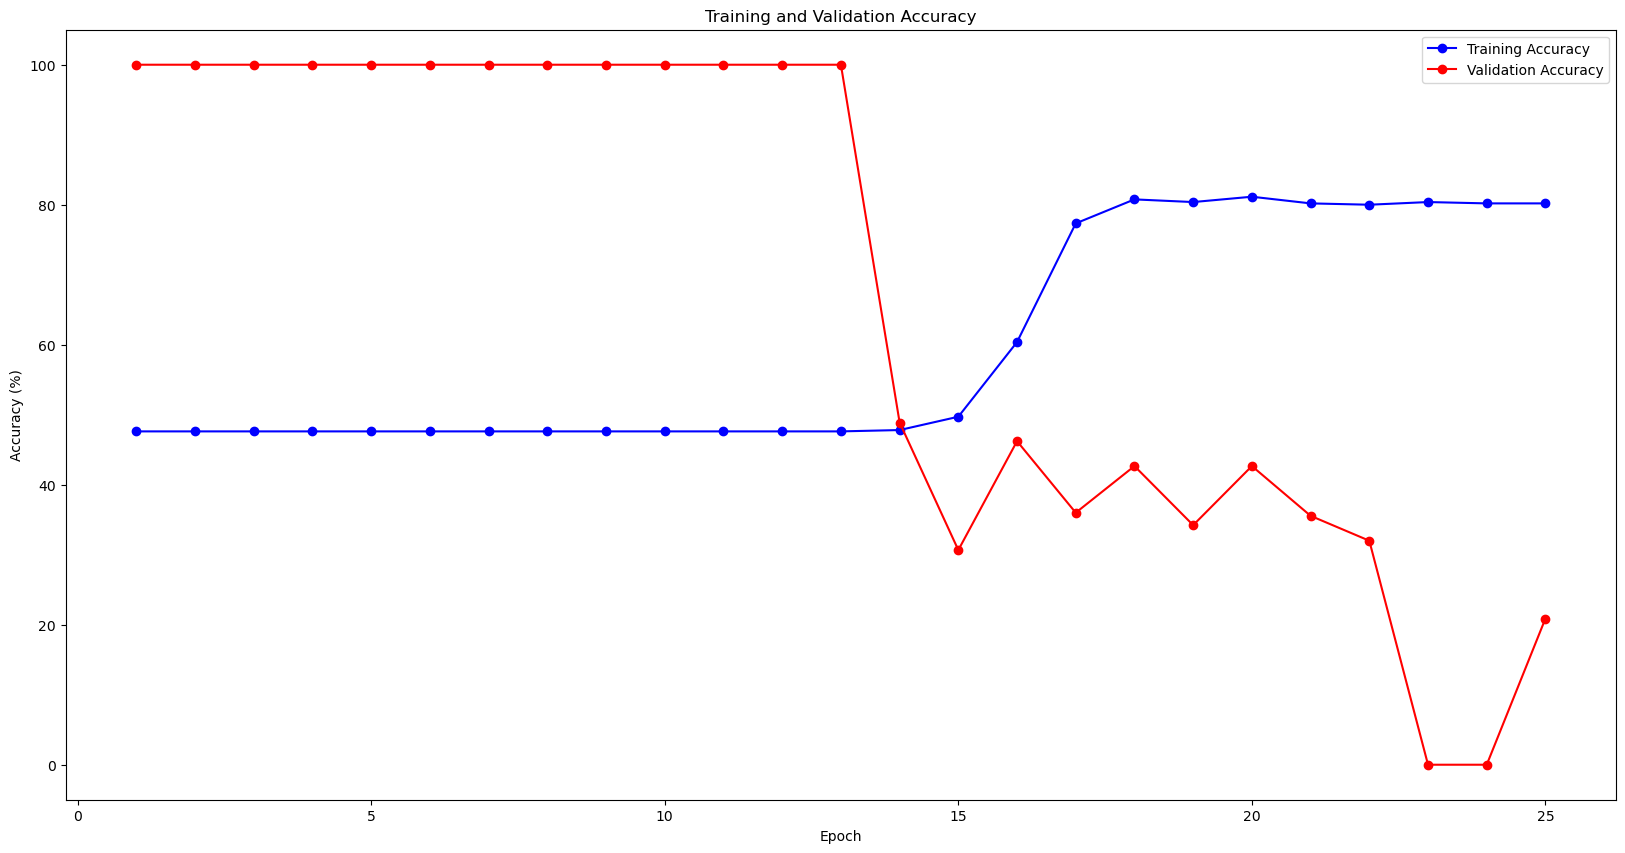

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(20, 10))
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(20, 10))
plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# define label mapping
label_mapping = {0: 'normal', 1: 'outer_break', 2: 'inner_break' }

predictions = []
with torch.no_grad():
    for data in tqdm(test_loader,desc = 'Predicting'):
        inputs = data

        inputs = inputs.unsqueeze(1)  #  (batch_size, channels, length)
        
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())


string_predictions = [label_mapping[pred] for pred in predictions]

df = pd.DataFrame(string_predictions)
df.to_csv('./HW3.csv', header = False ,index = False)

print('HW3.csv has been saved.')


Predicting: 100%|██████████| 8/8 [00:00<00:00, 237.01it/s]

HW3.csv has been saved.


In [ ]:
import torch
model = torch.jit.load('model_27.pt')
print(model)
model.eval()

RecursiveScriptModule(
  original_name=mod_resnet
  (conv1): RecursiveScriptModule(original_name=Conv1d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm1d)
  (maxpool): RecursiveScriptModule(original_name=MaxPool1d)
  (avgpool): RecursiveScriptModule(original_name=AdaptiveAvgPool1d)
  (fc): RecursiveScriptModule(original_name=Linear)
)


RecursiveScriptModule(
  original_name=mod_resnet
  (conv1): RecursiveScriptModule(original_name=Conv1d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm1d)
  (maxpool): RecursiveScriptModule(original_name=MaxPool1d)
  (avgpool): RecursiveScriptModule(original_name=AdaptiveAvgPool1d)
  (fc): RecursiveScriptModule(original_name=Linear)
)

In [ ]:
device = 'cuda'
with torch.no_grad():
        for inputs, labels in tqdm(val_loader,desc = f'val_samples:{len(val_loader.dataset)}'):

            inputs = inputs.unsqueeze(1)  # (batch_size, channels, length)
            inputs = inputs.to(device)
            labels = labels.to(device)
            

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loss = running_loss / len(val_loader) 
            val_acc = 100 * correct / total
            print(f'Epoch [{epoch+1}/{num_epochs}], phase: val, Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.2f}%')

val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 22.31it/s]

Epoch [25/25], phase: val, Loss: 1.1459, Val_Accuracy: 22.18%
Epoch [25/25], phase: val, Loss: 1.3186, Val_Accuracy: 24.57%
Epoch [25/25], phase: val, Loss: 1.4973, Val_Accuracy: 25.55%
Epoch [25/25], phase: val, Loss: 1.6709, Val_Accuracy: 27.20%
Epoch [25/25], phase: val, Loss: 1.8495, Val_Accuracy: 27.53%
Epoch [25/25], phase: val, Loss: 2.0255, Val_Accuracy: 27.82%
Epoch [25/25], phase: val, Loss: 2.2155, Val_Accuracy: 27.39%
Epoch [25/25], phase: val, Loss: 2.4112, Val_Accuracy: 27.33%
